In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils
import cv2
from pathlib import Path


In [2]:
new_model = tf.keras.models.load_model("mathematical_expressionv7.model")
class_names = ['(', ')', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'div', 'times']
kernel = np.ones((5, 5), np.uint8)

In [3]:
def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\hp\AppData\Local\Temp\ipykernel_15580\3493406575.py:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided


In [4]:
def image_to_tensor(img):
    white = [255,255,255]
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=white)
    #inp = cv2.resize(img, (45, 45))
    inp = resizeAndPad(img, (45,45), 255)
    cv2.imwrite("ROI{}.jpg".format(count), inp)
    im_rgb = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
    #plt.imshow(inp)
    rgb_tensor = tf.convert_to_tensor(im_rgb, dtype=tf.uint8)
    #Add dims to rgb_tensor
    rgb_tensor = tf.expand_dims(rgb_tensor, 0)
    
    return rgb_tensor

In [59]:
image = cv2.imread('deneme.jpg')
font = cv2.FONT_HERSHEY_SIMPLEX
scale_percent = 70
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
print(image.shape[0] * image.shape[1])
if(image.shape[0] * image.shape[1] > 500000):
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    resized_area = resized.shape[0] * resized.shape[1]
    print(resized_area)
else:
    resized = image.copy()
count = 0
#image = cv2.resize(image,(512,512))
ret, thresh = cv2.threshold(resized, 120, 255, cv2.THRESH_BINARY)
gray = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(gray, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
chars=[]
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    # extract the character and threshold it to make the character
    # appear as *white* (foreground) on a *black* background, then
    # grab the width and height of the thresholded image
    if resized_area > 500000:
        if w*h> 0.0015 * resized_area:
            roi = gray[y:y + h, x:x + w]
            #print(roi.shape)
            chars.append(image_to_tensor(roi))
            cv2.rectangle(resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
            count += 1
            pred = new_model.predict(image_to_tensor(roi))
            new_pred = np.argmax(pred)
            cv2.putText(resized,class_names[new_pred],(x,y-5), font, 1,(255,255,255),1,cv2.LINE_AA)
            print(class_names[new_pred])
    else:
        if w*h> 0.002 * resized_area:
            roi = gray[y:y + h, x:x + w]
            #print(roi.shape)
            chars.append(image_to_tensor(roi))
            cv2.rectangle(resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
            count += 1
            pred = new_model.predict(image_to_tensor(roi))
            new_pred = np.argmax(pred)
            cv2.putText(resized,class_names[new_pred],(x,y-5), font, 1,(255,255,255),1,cv2.LINE_AA)
            print(class_names[new_pred])

1006400
492800
1/1 [==============================] - 0s 17ms/step
9
1/1 [==============================] - 0s 17ms/step
+
1/1 [==============================] - 0s 18ms/step
3
1/1 [==============================] - 0s 18ms/step
-
1/1 [==============================] - 0s 18ms/step
(
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 18ms/step
times
1/1 [==============================] - 0s 17ms/step
2
1/1 [==============================] - 0s 19ms/step
-
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 18ms/step
)


(440, 1120, 3)

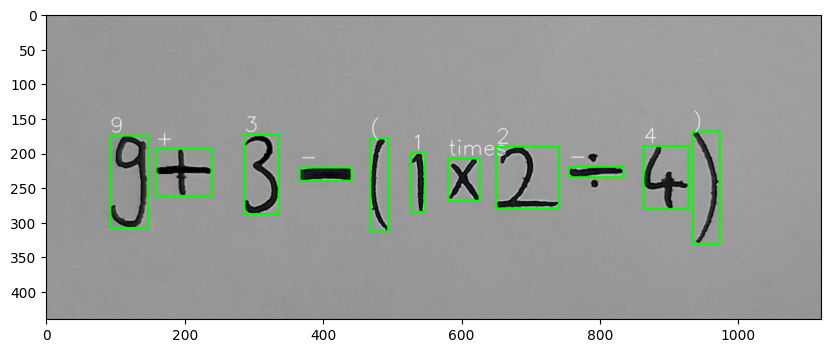

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(resized)
resized.shape